In [1]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('/kaggle/input/ipinyou-season-3/parsed_final_data_season_3.csv')
test_df = pd.read_csv('/kaggle/input/ipinyou-season-3/final_test_data_season_3.csv')

/tmp/ipykernel_19/616515770.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/ipinyou-season-3/parsed_final_data_season_3.csv')


In [3]:
train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)

In [4]:
train_df = train_df.fillna(value=False)

/tmp/ipykernel_19/1533110392.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.fillna(value=False)


In [5]:
pairs_for_union = [('weekend', 'weekday'), ('city_id', 'weekday'), ('browser','is_male'),
                  ('city_id', 'ad_slot_format'), 
                  ('weekend', 'browser'), ('region_id', 'is_in_market')]

In [6]:
new_feat_names = []
for f1, f2 in pairs_for_union:
    new_name = f"{f1}__{f2}"
    new_feat_names.append(new_name)
    for df in [train_df, test_df]:
        df[new_name] = df[f1].astype(str) + "_" + df[f2].astype(str)

In [7]:
target_column = 'click'
categorical_features = [
    'region_id', 'city_id', 'ad_slot_visibility', 'ad_slot_format',
    'creative_id', 'advertiser_id', 'part_of_day', 'weekday', 'weekend',
    'os', 'browser', 'is_in_market', 'is_male'
] + new_feat_names
feature_columns = categorical_features + ["ad_slot_screen_share"]

In [8]:
class_counts = train_df[target_column].value_counts()
class_counts

click
False    21329922
True        11673
Name: count, dtype: int64

In [9]:
class_0_count = class_counts.get(0, 1)
class_1_count = class_counts.get(1, 1)

/tmp/ipykernel_19/780349676.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_0_count = class_counts.get(0, 1)
/tmp/ipykernel_19/780349676.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_1_count = class_counts.get(1, 1)


In [10]:
total_count = class_0_count + class_1_count
class_weights = [total_count / class_0_count, total_count / class_1_count]

In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42, stratify=train_df[target_column])
val_df, _ = train_test_split(val_df, test_size=0.8, random_state=42, stratify=val_df[target_column])

In [12]:
train_pool = Pool(data=train_df[feature_columns],
                  label=train_df[target_column],
                  cat_features=categorical_features)

In [13]:
test_pool = Pool(data=test_df[feature_columns],
                 label=test_df[target_column],
                 cat_features=categorical_features)

In [14]:
val_pool = Pool(data=val_df[feature_columns],
                 label=val_df[target_column],
                 cat_features=categorical_features)

0:	learn: 0.6694131	test: 0.6694285	best: 0.6694285 (0)	total: 236ms	remaining: 23.4s
1:	learn: 0.6501848	test: 0.6499359	best: 0.6499359 (1)	total: 363ms	remaining: 17.8s
2:	learn: 0.6323116	test: 0.6317294	best: 0.6317294 (2)	total: 482ms	remaining: 15.6s
3:	learn: 0.6170956	test: 0.6162851	best: 0.6162851 (3)	total: 602ms	remaining: 14.5s
4:	learn: 0.6048020	test: 0.6037779	best: 0.6037779 (4)	total: 713ms	remaining: 13.5s
5:	learn: 0.5934588	test: 0.5924544	best: 0.5924544 (5)	total: 823ms	remaining: 12.9s
6:	learn: 0.5839171	test: 0.5828586	best: 0.5828586 (6)	total: 929ms	remaining: 12.3s
7:	learn: 0.5750076	test: 0.5738181	best: 0.5738181 (7)	total: 1.04s	remaining: 11.9s
8:	learn: 0.5636539	test: 0.5623333	best: 0.5623333 (8)	total: 1.14s	remaining: 11.6s
9:	learn: 0.5501588	test: 0.5489098	best: 0.5489098 (9)	total: 1.25s	remaining: 11.2s
10:	learn: 0.5444741	test: 0.5431257	best: 0.5431257 (10)	total: 1.36s	remaining: 11s
11:	learn: 0.5374439	test: 0.5358234	best: 0.5358234 (

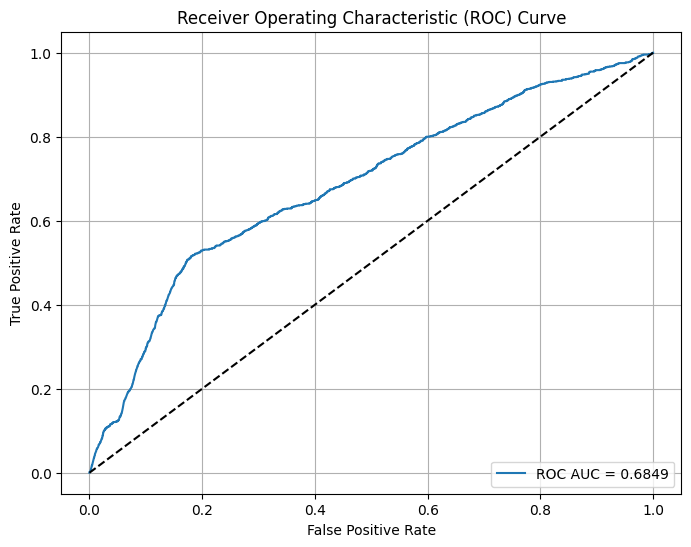

In [15]:
model = CatBoostClassifier(iterations=100, 
                           learning_rate=0.05, 
                           depth=5, 
                           task_type='GPU',
                           loss_function='Logloss',
                           class_weights=class_weights,
                           eval_metric='Logloss',
                           l2_leaf_reg=4)

model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

predictions = model.predict_proba(test_pool)[:, 1]

roc_auc = roc_auc_score(test_df[target_column], predictions)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(test_df[target_column], predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

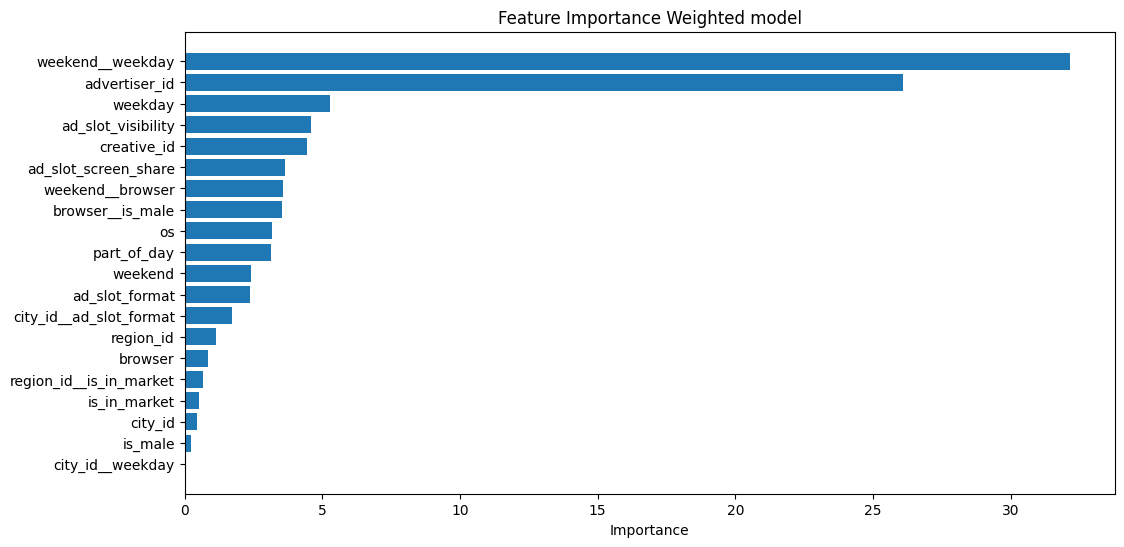

In [16]:
feature_importances = model.get_feature_importance(train_pool)
feature_importances_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})

feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance Weighted model')
plt.gca().invert_yaxis()
plt.show()